In [6]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,naive_bayes,preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import warnings
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
stemmer = PorterStemmer()
warnings.filterwarnings('ignore')
mypca = PCA(0.95)
lda = LinearDiscriminantAnalysis(n_components=1)

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [8]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=="Neutral":
            y.values[i]=0.0
        else:
            y.values[i]=1.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

def select_n_components(ratio, goal):
        # Set initial variance explained so far
        s=0.0 
        # Set initial number of features
        num_components = 0

        for i in ratio:
            s += i
            num_components += 1
            if s >= goal:
                break

        # Return the number of components
        return num_components

In [9]:
with open("Tech_news.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

X=X.sort_values("Date")
print("Number of Examples : ",len(X))
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")
X.to_csv (r'Tech.csv', index = False, header=True)

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n")

y=target_arrange(X['Target'])

print("Neutral Examples : ",(y==0.0).sum())
print("Not Neutral Examples : ",(y==1.0).sum())

Number of Examples :  18187
Number of Examples after removing duplicates:  17852 

Number of words before cleaning :  672140
Number of words after cleaning :  452084


Neutral Examples :  8987
Not Neutral Examples :  8865


In [10]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])

print(X['Article'])

0        mercuri system receiv contract award base new ...
1        progress second quarter revenu exce guidanc in...
2        acuiti brand declar quarterli dividend atlanta...
3         share factset soar today earn came better expect
4        stifel say inseego leader inseego corp nasdaq ...
                               ...                        
17847    appl app store polici updat affect microsoft g...
17848    investor action remind schall law firm announc...
17849    amwel propos term million ipo amwel seek rais ...
17850    jim cramer preview lennar fedex adob earn repo...
17851    rosen respect lead law firm remind alteryx inc...
Name: Article, Length: 17852, dtype: object


In [11]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9,min_df=5)
Xv = tfidf_vectorizer.fit_transform(X['Article'])
Xv = pd.DataFrame(Xv.todense())
X_train,X_test,y_train,y_test = train_test_split(Xv,y, test_size=0.3,stratify=y)

#PCA and LDA for SVM

scaler = MinMaxScaler()
X_train1 = scaler.fit_transform(X_train)
X_test1 = scaler.transform(X_test)

X_train_pca = mypca.fit_transform(X_train1)
X_test_pca = mypca.transform(X_test1)

X_train_pca = lda.fit_transform(X_train_pca, y_train)
X_test_pca  = lda.transform(X_test_pca)


## Naive Bayes


Metrics

 Recall metric: 0.8225438410566476
 F1 metric: 0.821310008232121
 Precision metric: 0.8287025214597992
 Accuracy metric: 0.822068707991038
 Balanced Accuracy metric: 0.8225438410566476 

**************************************************

Normalized confusion matrix
[[0.75 0.25]
 [0.11 0.89]]


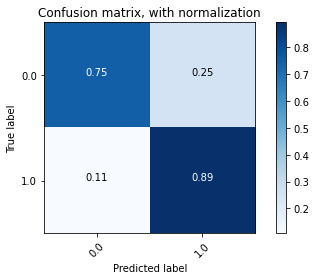

In [12]:
alpha = 0.1 # This is the smoothing parameter for Laplace/Lidstone smoothing
model = naive_bayes.MultinomialNB(alpha=alpha)

model.fit(X_train,y_train)
y_predicted = model.predict(X_test)

print("\nMetrics\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0.0, 1.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0],
                      title='Confusion matrix, with normalization')


## Random Forest 


Metrics

 Recall metric: 0.851132281742933
 F1 metric: 0.8505762309151366
 Precision metric: 0.8538411448727521
 Accuracy metric: 0.8508215085884989
 Balanced Accuracy metric: 0.851132281742933 

**************************************************

Normalized confusion matrix
[[0.8 0.2]
 [0.1 0.9]]


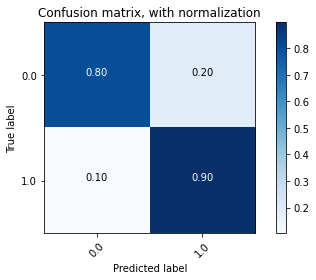

In [13]:
model2 = RandomForestClassifier(n_estimators=100, max_features="auto", n_jobs=-1,class_weight='balanced')
model2.fit(X_train,y_train)
y_predicted = model2.predict(X_test)

print("\nMetrics\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0.0, 1.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0],
                      title='Confusion matrix, with normalization')

## SVM

{'C': 0.005, 'gamma': 1, 'kernel': 'rbf'}

Metrics

 Recall metric: 0.838678577006314
 F1 metric: 0.8384269605946049
 Precision metric: 0.8394756016578604
 Accuracy metric: 0.8384988797610157
 Balanced Accuracy metric: 0.838678577006314 

**************************************************

Normalized confusion matrix
[[0.81 0.19]
 [0.13 0.87]]


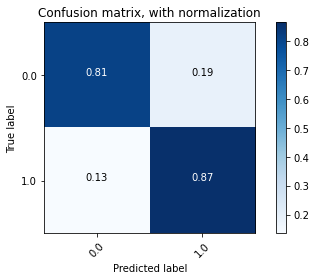

In [14]:
tuned_parameters = [
  
  {'C': [0.005, 0.01, 0.03, 0.1, 1, 10, 100 ], 'gamma': [5, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], 'kernel': ['rbf']}
  
 ]

grid = GridSearchCV(SVC(class_weight='balanced', decision_function_shape='ovr'), tuned_parameters, n_jobs=-1, refit = True, cv=5) 
grid.fit(X_train_pca, y_train) 
print(grid.best_params_) 
grid_predictions = grid.predict(X_test_pca) 

print("\nMetrics\n")
recall = metrics.recall_score(y_test,grid_predictions ,average='macro')
precision = metrics.precision_score(y_test,grid_predictions ,average='macro')
f1 = metrics.f1_score(y_test,grid_predictions ,average='macro')
Accur=metrics.accuracy_score(y_test,grid_predictions )
B_Accur=metrics.balanced_accuracy_score(y_test,grid_predictions )

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, grid_predictions ,labels=[0.0, 1.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0],
                      title='Confusion matrix, with normalization')